In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.utils import shuffle
import numpy as np

2023-05-28 13:18:28.263024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 13:18:28.543462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-28 13:18:28.543487: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-28 13:18:29.909793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [3]:
(x_train, y_train), (x_test, y_test) = data

In [4]:
fives_train, f_train = x_train[y_train == 5], y_train[y_train == 5]
five_train_index = np.random.choice(fives_train.shape[0], 500)
fives_train = fives_train[five_train_index]
f_train = f_train[five_train_index]

fives_test, f_test = x_test[y_test == 5], y_test[y_test == 5]
five_test_index = np.random.choice(fives_test.shape[0], 250)
fives_test = fives_test[five_test_index]
f_test = f_test[five_test_index]

In [5]:
ones_train, o_train = x_train[y_train == 1], y_train[y_train == 1]
ones_train_index = np.random.choice(ones_train.shape[0], 500)
ones_train = ones_train[ones_train_index]
o_train = o_train[ones_train_index]

ones_test, o_test = x_test[y_test == 1], y_test[y_test == 1]
ones_test_index = np.random.choice(ones_test.shape[0], 250)
ones_test = ones_test[ones_test_index]
o_test = o_test[ones_test_index]

In [6]:
train, test = np.vstack((fives_train, ones_train)), np.vstack((fives_test, ones_test))
target_train, target_test = np.hstack((f_train, o_train)), np.hstack((f_test, o_test))

In [7]:
target_train[0]

5

In [8]:
set_train, t_train = shuffle(train, target_train, random_state=0)
set_test, t_test = shuffle(test, target_test, random_state=0)

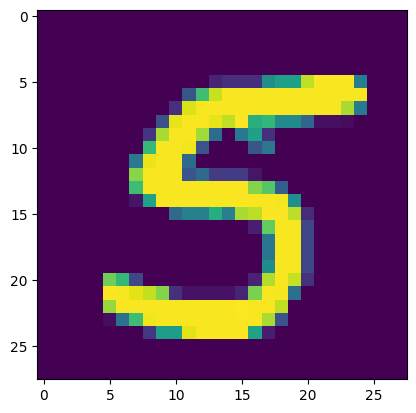

In [9]:
plt.imshow(set_train[7])

In [10]:
t_train = t_train.astype(np.int64)
t_test = t_test.astype(np.int64)

In [11]:
t_train[t_train == 1] = 0
t_train[t_train == 5] = 1
t_test[t_test == 1] = 0
t_test[t_test == 5] = 1

In [12]:
set_train_color = np.array([cv.resize(cv.cvtColor(img, cv.COLOR_GRAY2RGB), (64, 64)) for img in set_train]).astype('float32')
set_test_color = np.array([cv.resize(cv.cvtColor(img, cv.COLOR_GRAY2RGB), (64, 64)) for img in set_test]).astype('float32')
t_train = tf.keras.utils.to_categorical(t_train)
t_test = tf.keras.utils.to_categorical(t_test)

In [13]:
t_train[7]

array([0., 1.], dtype=float32)

In [14]:
set_train_color.shape

(1000, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


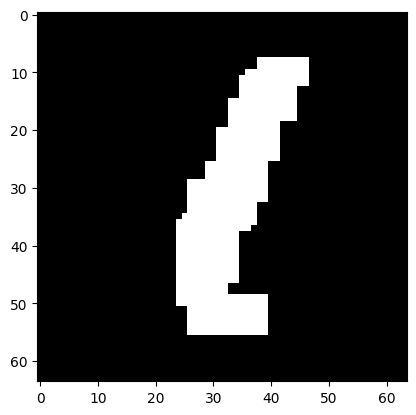

In [15]:
plt.imshow(set_train_color[0])

In [16]:
vgg = VGG19(input_shape=[64,64] + [3], weights='imagenet', include_top=False)

2023-05-28 13:18:46.096107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-28 13:18:46.096165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-05-28 13:18:46.096746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
for layer in vgg.layers:
  layer.trainable = False

In [18]:
x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(2, activation='softmax')(x)

In [22]:
model = tf.keras.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [23]:
set_train_color.shape

(1000, 64, 64, 3)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(set_train_color, t_train, validation_data=(set_test_color, t_test), epochs=5)

Epoch 1/5
32/32 [==============================] - 26s 791ms/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.0251 - val_accuracy: 0.9960
Epoch 2/5
32/32 [==============================] - 26s 818ms/step - loss: 2.2641e-06 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9960
Epoch 3/5
32/32 [==============================] - 26s 821ms/step - loss: 6.1278e-07 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9960
Epoch 4/5
32/32 [==============================] - 26s 827ms/step - loss: 4.3115e-07 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9960
Epoch 5/5
32/32 [==============================] - 29s 902ms/step - loss: 3.5522e-07 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9980


In [ ]:
def print_result(y_target, y_predict):
    print(f'Accuracy: {accuracy_score(y_target, y_predict)}')
    print(f'Recall: {recall_score(y_target, y_predict)}')
    print(f'Precision: {precision_score(y_target, y_predict)}')
    print(f'F1-score: {f1_score(y_target, y_predict)}')

In [30]:
y_test = np.argmax(t_test, axis=1)
y_pred = np.argmax(model.predict(set_test_color), axis=1)

32/32 [==============================] - 4s 117ms/step


In [31]:
print_result(y_test, y_pred)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-score: 1.0


In [25]:
five1 = 255 - cv.imread('/home/petro/Pictures/test/five1.png', cv.IMREAD_COLOR)
five2 = 255 - cv.imread('/home/petro/Pictures/test/five2.png', cv.IMREAD_COLOR)
five3 = 255 - cv.imread('/home/petro/Pictures/test/five3.png', cv.IMREAD_COLOR)
five4 = 255 - cv.imread('/home/petro/Pictures/test/five4.png', cv.IMREAD_COLOR)

one1 = 255 - cv.imread('/home/petro/Pictures/test/one1.png', cv.IMREAD_COLOR)
one2 = 255 - cv.imread('/home/petro/Pictures/test/one2.png', cv.IMREAD_COLOR)
one3 = 255 - cv.imread('/home/petro/Pictures/test/one3.png', cv.IMREAD_COLOR)
one4 = 255 - cv.imread('/home/petro/Pictures/test/one4.png', cv.IMREAD_COLOR)

imgs = [five1, five2, five3, five4, one1, one2, one3, one4]

In [26]:
img_test = []
for img in imgs:
    img_test.append(cv.resize(img, (32, 32)))
img_test = np.array(img_test)

In [27]:
img_test.shape

(8, 32, 32, 3)

In [28]:
np.argmax(model.predict(img_test), axis=1)

1/1 [==============================] - 0s 224ms/step


array([1, 1, 1, 1, 0, 0, 0, 0])

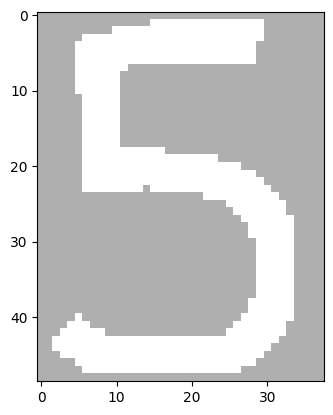

In [73]:
plt.imshow(imgs[3])